In [1]:
import pandas as pd  #pandas does things with matrixes
import numpy as np #used for sorting a matrix
import matplotlib.pyplot as plt #matplotlib is used for plotting data
import matplotlib.ticker as ticker #used for changing tick spacing
import datetime as dt #used for dates
import matplotlib.dates as mdates #used for dates, in a different way
import os #used for changes of directory
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

import sys
sys.path.append('../')
from utils import *

In [2]:
dataset_1yr = pd.read_csv("../../Data/all_stocks_5yr.csv")
dataset_1yr.head()

# Changing the date column to the datetime format (best format to work with time series)
dataset_1yr['Date'] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dataset_1yr['Date']]

dataset_1yr.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [3]:
# Assigning a mid price column with the mean of the Highest and Lowest values

dataset_1yr['Mid'] = (dataset_1yr['High'] + dataset_1yr['Low'])/2
dataset_1yr.head()

,Date,Open,High,Low,Close,Volume,Name,Mid
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM,92.165
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM,92.255
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM,92.340
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM,93.040
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM,93.945


In [4]:
# Getting rid of null columns

missing_data = pd.DataFrame(dataset_1yr.isnull().sum()).T
print(missing_data)

for index, column in enumerate(missing_data.columns):
    if missing_data.loc[0][index] != 0:
        dataset_1yr = dataset_1yr.drop(dataset_1yr.loc[dataset_1yr[column].isnull()].index)
        
missing_data = pd.DataFrame(dataset_1yr.isnull().sum()).T
print(missing_data)

   Date  Open  High  Low  Close  Volume  Name  Mid
0     0   384   208  227      0     406     0  358
   Date  Open  High  Low  Close  Volume  Name  Mid
0     0     0     0    0      0       0     0    0


In [5]:
# Let's analyze 3M stocks a bit deeper

MMM_stocks = dataset_1yr[dataset_1yr['Name'] == 'MMM']

MMM_stocks.head()

,Date,Open,High,Low,Close,Volume,Name,Mid
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM,92.165
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM,92.255
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM,92.340
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM,93.040
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM,93.945


In [6]:
# Creating a trend feature

trend_term = [0]
temp = 0
for term in range(len(MMM_stocks['Close']) - 1):
    temp = MMM_stocks['Close'].iloc[term + 1] - MMM_stocks['Close'].iloc[term]
    if temp > 0:
        trend_term.append(1)
    elif temp < 0:
        trend_term.append(-1)
    else:
        trend_term.append(0)

MMM_stocks['Trend_term'] = pd.DataFrame(np.array(trend_term))

In [7]:
# Creating a percent change column related to the closing price

percent_change_closing_price = MMM_stocks['Close'].pct_change()
percent_change_closing_price.fillna(0, inplace=True)
MMM_stocks['PC_change'] = pd.DataFrame(percent_change_closing_price)

# As we want to predict the closing price, let's add the target column as the close price shifted by 1

MMM_stocks['Target'] = MMM_stocks['Close'].shift(-1)

MMM_stocks = MMM_stocks.drop(0, axis = 0)
MMM_stocks = MMM_stocks.drop('Name', axis = 1)
MMM_stocks = MMM_stocks.drop('Date', axis = 1)

MMM_stocks.head()

,Open,High,Low,Close,Volume,Mid,Trend_term,PC_change,Target
1,92.36,92.50,92.01,92.30,1843476.0,92.255,-1.0,-0.001082,92.54
2,92.00,92.74,91.94,92.54,1983395.0,92.340,1.0,0.002600,93.74
3,92.75,93.87,92.21,93.74,3395145.0,93.040,1.0,0.012967,94.24
4,93.93,94.30,93.59,94.24,3069513.0,93.945,1.0,0.005334,93.89
5,94.00,94.17,93.55,93.89,1640008.0,93.860,-1.0,-0.003714,93.21


In [8]:
# Separating as Training and Testing

train_data = MMM_stocks.iloc[:1000,:]
train_data = train_data.drop('Target',axis=1)
test_data = MMM_stocks.iloc[1000:,:]
test_data = test_data.drop('Target',axis=1)

y_train = MMM_stocks.iloc[:1000,-1]
y_test = MMM_stocks.iloc[1000:,-1]

print(train_data.shape)
print(test_data.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 8)
(256, 8)
(1000,)
(256,)


## Keras 1D - CNN for time series prediction

### 1D - CNN for 1 step ahead prediction with univariate input

#### Scaling the data

In [107]:
# Scaling Data for the Univariate Example

# Training Data

scaler_dataframe = StandardScaler()
training_scaled = pd.DataFrame(scaler_dataframe.fit_transform(np.array(train_data['Close']).reshape(-1,1)))
#print(training_scaled.head())

# Testing Data
testing_scaled = pd.DataFrame(scaler_dataframe.transform(np.array(test_data['Close']).reshape(-1,1)))
#print(testing_scaled.head())

#### Data Pre-Processing
Rows for time steps and columns for parallel series (features)

In [108]:
# Preparing data for the experiment with an univariate model 
# Getting Closing Price and arranging lists for training/testing based on the sequence

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)  
    return np.array(X), np.array(y)

In [109]:
window_size = 10

train_univariate, y_train_univariate = split_sequence(np.array(training_scaled), window_size)
test_univariate, y_test_univariate = split_sequence(np.array(testing_scaled), window_size)

In [110]:
# Reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1

# Choose a number of time steps
n_steps = train_univariate.shape[1]

X = train_univariate.reshape(train_univariate.shape[0], train_univariate.shape[1], n_features) # Reshaping array in order to have a 3D input
y = y_train_univariate

print(X.shape)
print(y.shape)

(990, 10, 1)
(990, 1)


#### Model fitting

In [ ]:
# Define model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
_ = model.fit(X, y, epochs=200, verbose=0)

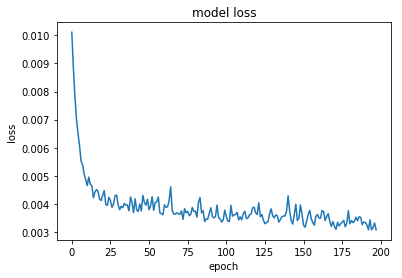

In [112]:
# Summarize history for loss

plt.plot(model.history.history['loss'][2:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [113]:
# Lets define a function that will do a fit after each prediction

def walk_foward_prediction(model, epoch_update, test_x, true_label):   
    predictions = []
    for i in range(test_x.shape[0]):
        predictions.append(model.predict(test_x[i], verbose=0))
        _ = model.fit(test_x[i], true_label[i], epochs=epoch_update, verbose=0)
    return predictions

In [99]:
print(test_univariate.shape)
print(y_test_univariate.shape)
print(x.shape)

(251, 5, 1)
(251, 1)
(251, 1, 5, 1)


In [114]:
y_pred = []
epochs = 10

x = test_univariate.reshape((test_univariate.shape[0], 1, n_steps, n_features))
y_pred = walk_foward_prediction(model, epochs, x, y_test_univariate)

In [15]:
# Checking with the testing data

y_pred = []

for i in range(test_univariate.shape[0]):
    test = test_univariate[i].reshape((1, n_steps, n_features))
    y_pred.append(model.predict(test, verbose=0))

In [115]:
horizon_predicted = scaler_dataframe.inverse_transform(np.array(y_pred).reshape(-1))
inverse_test_data = scaler_dataframe.inverse_transform(np.array(y_test_univariate).reshape(-1))
                                                       
MSE = mean_squared_error(inverse_test_data, horizon_predicted)
MAE = mean_absolute_error(inverse_test_data, horizon_predicted)
RMSE = np.sqrt(MSE)

TU_metric = TU(inverse_test_data, horizon_predicted)
POCID_metric = POCID(inverse_test_data, horizon_predicted)

print('Mean Squared Error (Testing Data): %.6f' % MSE)
print('Mean Absolute Error (Testing Data): %.6f' % MAE)
print('Root Mean Squared Error (Testing Data): %.6f' % RMSE)
print('TU: %.6f' % TU_metric)
print('Hit Rate Prediction of Change in Direction(POCID): %.6f' % POCID_metric)

Mean Squared Error (Testing Data): 3.102938
Mean Absolute Error (Testing Data): 1.231057
Root Mean Squared Error (Testing Data): 1.761516
TU: 1.488398
Hit Rate Prediction of Change in Direction(POCID): 46.122449


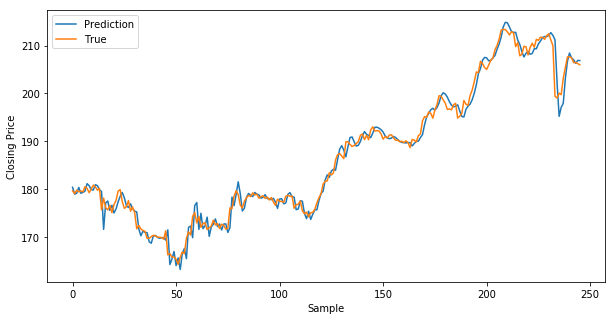

In [116]:
plt.figure(figsize = (10,5))

plt.plot(scaler_dataframe.inverse_transform(np.array(y_pred).reshape(-1)), label='Prediction')
plt.plot(scaler_dataframe.inverse_transform(np.array(y_test_univariate).reshape(-1)), label='True')
plt.xlabel('Sample')
plt.ylabel('Closing Price')
plt.legend(fontsize=10)

plt.show()

### 1D - CNN for 5 step ahead prediction with univariate input

#### - Need a fix in the error analysis and plot of outputs

In [35]:
# Split a univariate sequence into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [36]:
# Choose a number of time steps
n_steps_in, n_steps_out = 10, 5

n_features = 1 # Univariate

train_univariate, y_train_univariate = split_sequence(np.array(training_scaled), n_steps_in, n_steps_out)
test_univariate, y_test_univariate = split_sequence(np.array(testing_scaled), n_steps_in, n_steps_out)

In [38]:
X = train_univariate.reshape(train_univariate.shape[0], train_univariate.shape[1], n_features) # Reshaping array in order to have a 3D input
y = y_train_univariate.reshape(train_univariate.shape[0], n_steps_out)
print(X.shape)
print(y.shape)

(986, 10, 1)
(986, 5)


In [39]:
# Define model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

_ = model.fit(X, y, epochs=100)

Epoch 1/100
986/986 [==============================] - 1s 761us/sample - loss: 0.3963
Epoch 2/100
986/986 [==============================] - 0s 252us/sample - loss: 0.0274
Epoch 3/100
986/986 [==============================] - 0s 256us/sample - loss: 0.0188
Epoch 4/100
986/986 [==============================] - 0s 260us/sample - loss: 0.0170
Epoch 5/100
986/986 [==============================] - 0s 255us/sample - loss: 0.0154
Epoch 6/100
986/986 [==============================] - 0s 272us/sample - loss: 0.0146
Epoch 7/100
986/986 [==============================] - 0s 251us/sample - loss: 0.0134
Epoch 8/100
986/986 [==============================] - 0s 265us/sample - loss: 0.0126
Epoch 9/100
986/986 [==============================] - 0s 252us/sample - loss: 0.0121
Epoch 10/100
986/986 [==============================] - 0s 264us/sample - loss: 0.0118
Epoch 11/100
986/986 [==============================] - 0s 343us/sample - loss: 0.0112
Epoch 12/100
986/986 [==============================

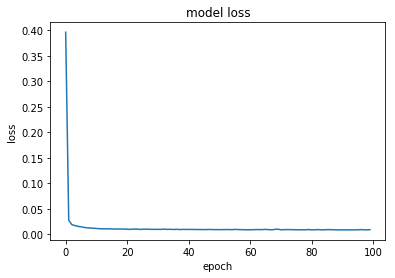

In [40]:
# Summarize history for loss

plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [42]:
# Checking with the testing data

y_pred = []

for i in range(test_univariate.shape[0]):
    test = test_univariate[i].reshape((1, n_steps_in, n_features))
    y_pred.append(model.predict(test, verbose=0))

In [43]:
horizon_predicted = scaler_dataframe.inverse_transform(np.array(y_pred).reshape(-1))
inverse_test_data = scaler_dataframe.inverse_transform(np.array(y_test_univariate).reshape(-1))
                                                       
MSE = mean_squared_error(inverse_test_data, horizon_predicted)
MAE = mean_absolute_error(inverse_test_data, horizon_predicted)
RMSE = np.sqrt(MSE)

TU_metric = TU(inverse_test_data, horizon_predicted)
POCID_metric = POCID(inverse_test_data, horizon_predicted)

print('Mean Squared Error (Testing Data): %.6f' % MSE)
print('Mean Absolute Error (Testing Data): %.6f' % MAE)
print('Root Mean Squared Error (Testing Data): %.6f' % RMSE)
print('TU: %.6f' % TU_metric)
print('Hit Rate Prediction of Change in Direction(POCID): %.6f' % POCID_metric)

Mean Squared Error (Testing Data): 8.667862
Mean Absolute Error (Testing Data): 2.127252
Root Mean Squared Error (Testing Data): 2.944123
TU: 2.864046
Hit Rate Prediction of Change in Direction(POCID): 50.620347


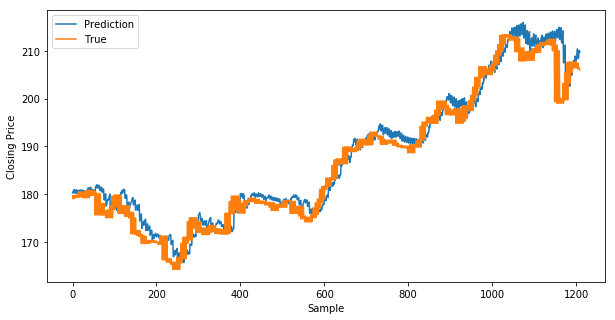

In [44]:
plt.figure(figsize = (10,5))

plt.plot(horizon_predicted, label='Prediction')
plt.plot(inverse_test_data, label='True')
plt.xlabel('Sample')
plt.ylabel('Closing Price')
plt.legend(fontsize=10)

plt.show()

## 1D - CNN Multivariate input example

### 1D - CNN for 1 step ahead prediction with multivariate input

In [118]:
# Training Data

scaler_dataframe = StandardScaler()
training_scaled = pd.DataFrame(scaler_dataframe.fit_transform(np.array(MMM_stocks.iloc[:1000,:])))
#print(training_scaled.head())

# Testing Data
testing_scaled = pd.DataFrame(scaler_dataframe.transform(np.array(MMM_stocks.iloc[1000:,:])))
#print(testing_scaled.head())

# Scaler for the final output based on the closing price column for the training set

closing_price_scaler = StandardScaler()
scaler_output = closing_price_scaler.fit(np.array(MMM_stocks.iloc[:1000,:]['Close']).reshape(-1,1))

#### Data Pre-Processing
Rows for time steps and columns for parallel series (features)

In [120]:
# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [121]:
window_size = 10
n_features = 8

train_univariate, y_train_univariate = split_sequences(np.array(training_scaled), window_size)
test_univariate, y_test_univariate = split_sequences(np.array(testing_scaled), window_size)

print(train_univariate.shape)
print(y_train_univariate.shape)

(990, 10, 8)
(990,)


#### Model fitting

In [147]:
# Define model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
_ = model.fit(train_univariate, y_train_univariate, epochs=200, verbose = 0)

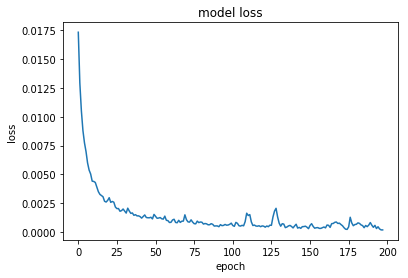

In [148]:
# Summarize history for loss

plt.plot(model.history.history['loss'][2:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [149]:
# Using the Walk Foward Validation Strategy

y_pred = []
epochs = 10

test = test_univariate.reshape((test_univariate.shape[0], 1, window_size, n_features))
y_test = y_test_univariate.reshape(y_test_univariate.shape[0],1)

y_pred = walk_foward_prediction(model, epochs, test, y_test)

In [131]:
# Checking with the testing data

#y_pred = []

#for i in range(test_univariate.shape[0]):
#    test = test_univariate[i].reshape((1, window_size, n_features))
#    y_pred.append(model.predict(test, verbose=0))

In [150]:
horizon_predicted = scaler_output.inverse_transform(np.array(y_pred).reshape(-1))
inverse_test_data = scaler_output.inverse_transform(np.array(y_test_univariate).reshape(-1))
                                                       
MSE = mean_squared_error(inverse_test_data, horizon_predicted)
MAE = mean_absolute_error(inverse_test_data, horizon_predicted)
RMSE = np.sqrt(MSE)

TU_metric = TU(inverse_test_data, horizon_predicted)
POCID_metric = POCID(inverse_test_data, horizon_predicted)

print('Mean Squared Error (Testing Data): %.6f' % MSE)
print('Mean Absolute Error (Testing Data): %.6f' % MAE)
print('Root Mean Squared Error (Testing Data): %.6f' % RMSE)
print('TU: %.6f' % TU_metric)
print('Hit Rate Prediction of Change in Direction(POCID): %.6f' % POCID_metric)

Mean Squared Error (Testing Data): 3.626362
Mean Absolute Error (Testing Data): 1.404752
Root Mean Squared Error (Testing Data): 1.904301
TU: 1.738594
Hit Rate Prediction of Change in Direction(POCID): 44.897959


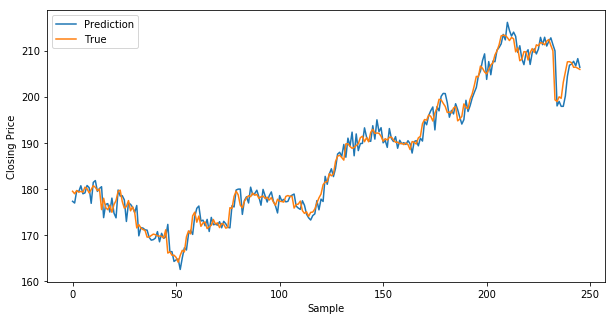

In [152]:
plt.figure(figsize = (10,5))

plt.plot(horizon_predicted, label='Prediction')
plt.plot(inverse_test_data, label='True')
plt.xlabel('Sample')
plt.ylabel('Closing Price')
plt.legend(fontsize=10)
plt.show()

### 1D CNN for multi-step ahead prediction with multivariate input

In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
# Training Data

scaler_dataframe = StandardScaler()
training_scaled = pd.DataFrame(scaler_dataframe.fit_transform(np.array(MMM_stocks.iloc[:1000,:])))
#print(training_scaled.head())

# Testing Data
testing_scaled = pd.DataFrame(scaler_dataframe.transform(np.array(MMM_stocks.iloc[1000:,:])))
#print(testing_scaled.head())

# Scaler for the final output based on the closing price column for the training set

closing_price_scaler = StandardScaler()
scaler_output = closing_price_scaler.fit(np.array(MMM_stocks.iloc[:1000,:]['Close']).reshape(-1,1))

In [ ]:
# Choose a number of time steps
n_features = 8
n_steps_in, n_steps_out = 10, 5

train_multivariate, y_train_multivariate = split_sequences(np.array(training_scaled), n_steps_in, n_steps_out)
test_multivariate, y_test_multivariate = split_sequences(np.array(testing_scaled), n_steps_in, n_steps_out)

#print(train_multivariate.shape)
#print(y_train_multivariate.shape)

In [ ]:
X = train_multivariate.reshape(train_multivariate.shape[0], train_multivariate.shape[1], n_features) # Reshaping array in order to have a 3D input
y = y_train_multivariate.reshape(train_multivariate.shape[0], n_steps_out)
print(X.shape)
print(y.shape)

#### Model fitting

In [ ]:
# Define model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000)

In [ ]:
# Summarize history for loss

plt.plot(model.history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Checking with the testing data

y_pred = []

for i in range(test_multivariate.shape[0]):
    test = test_multivariate[i].reshape((1, n_steps_in, n_features))
    y_pred.append(model.predict(test, verbose=0))

In [ ]:
horizon_predicted = scaler_output.inverse_transform(np.array(y_pred).reshape(-1))[:-1] # Just to take care of the NaN
inverse_test_data = scaler_output.inverse_transform(np.array(y_test_multivariate).reshape(-1))[:-1] # Just to take care of the NaN
                                                       
MSE = mean_squared_error(inverse_test_data, horizon_predicted)
MAE = mean_absolute_error(inverse_test_data, horizon_predicted)
RMSE = np.sqrt(MSE)

TU_metric = TU(inverse_test_data, horizon_predicted)
POCID_metric = POCID(inverse_test_data, horizon_predicted)

print('Mean Squared Error (Testing Data): %.6f' % MSE)
print('Mean Absolute Error (Testing Data): %.6f' % MAE)
print('Root Mean Squared Error (Testing Data): %.6f' % RMSE)
print('TU: %.6f' % TU_metric)
print('Hit Rate Prediction of Change in Direction(POCID): %.6f' % POCID_metric)

In [ ]:
plt.figure(figsize = (10,5))

plt.plot(horizon_predicted, label='Prediction')
plt.plot(inverse_test_data, label='True')
plt.xlabel('Sample')
plt.ylabel('Closing Price')
plt.legend(fontsize=10)

plt.show()

### To be done: Multi-Head 1D CNN for Multi-variate Input
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/